In [1]:
import numpy as np 

from optiland import optic
from optiland.materials import Material
from optiland.apodization import GaussianApodization

from classes.cartesian_oval import CartesianOvalCollimator
from classes.gaussian_beam import GaussianBeam
from classes.beam_shaper import BeamShaper

In [35]:
# Gaussian Source Parameters
wavelength = np.array([1.55]) # in micrometers
omega_0 = 5.2 # in micrometers

In [36]:
H_LAF3B = Material(name="H-LAF3B")
print(H_LAF3B.n(wavelength[0]))

index1 = float(H_LAF3B.n(wavelength = wavelength[0]))

[1.718545]


C:\Users\shown\AppData\Local\Temp\ipykernel_28312\2153177057.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index1 = float(H_LAF3B.n(wavelength = wavelength[0]))


In [37]:
source = GaussianBeam(
    wavelength=float(wavelength[0]),
    omega_0=omega_0,
)

beam_size = source.beam_radius(z=30) # in millimeters at z = 30 mm

semi_dia = np.ceil(beam_size)

# Glass: CDGM H-LAF3B
collimator = CartesianOvalCollimator(
    z_0=30, # in millimeters
    n = index1, # refractive index of the collimator material
    r_max=semi_dia, # in millimeters    
)

approx_ea = collimator.paraxial_fit()
fitted_ea = collimator.even_aspheric_fitting(approx_ea)


In [38]:
print("Source Information:")
print(f"omega(z=30mm): {beam_size} millimeters")
print("Rayleigh Range: {:.4f} um".format(source.rayleigh_range))
print("Divergence Angle (half-angle): {:.4f} urad".format(source.div_angle * 1e3))
print("Divergence Angle (half-angle): {:.4f} degrees".format(np.degrees(source.div_angle)))
print("Divergence Angle at z = 30 mm: {:.4f} degrees".format(np.degrees(source.div_angle_z(z=30))))
print("object NA=", np.sin(source.div_angle))


Source Information:
omega(z=30mm): 2.846429693572783 millimeters
Rayleigh Range: 54.8056 um
Divergence Angle (half-angle): 94.8808 urad
Divergence Angle (half-angle): 5.4363 degrees
Divergence Angle at z = 30 mm: 5.4201 degrees
object NA= 0.09473853676366122


In [39]:
print("Collimator Surface Information:")
print(f"Collimator semi-diameter: {collimator.r_max} millimeters")
print("\n")
print(f"Paraxial fit radius: {approx_ea.vertex_r} millimeters")
print(f"Paraxial fit conic constant: {approx_ea.k}")
print("\n")
print(f"Fitted even aspheric radius: {fitted_ea.vertex_r} millimeters")
print(f"Fitted even aspheric conic constant: {fitted_ea.k}")

Collimator Surface Information:
Collimator semi-diameter: 3.0 millimeters


Paraxial fit radius: 21.556350116103832 millimeters
Paraxial fit conic constant: -2.9533969303269774


Fitted even aspheric radius: 21.556350116103832 millimeters
Fitted even aspheric conic constant: -2.9533969303269774


In [44]:
emitter = optic.Optic()

# Set System Data
emitter.set_aperture(aperture_type="objectNA", value=np.sin(source.div_angle)) # "EPD", "imageFNO"

emitter.set_field_type(field_type = "angle") # "object_height"; "paraxial_image_height"; "real_image_height"; "angle"
emitter.add_field(y=0)

emitter.add_wavelength(value=wavelength[0], is_primary=True)

gaussian_apo = GaussianApodization(sigma=1/np.sqrt(2)) # I = exp(-(Px^2 + Py^2) / (2 * self.sigma^2)) => sigma = 1/sqrt(2G) where apodization factor G = 1 in this case 
emitter.set_apodization(gaussian_apo)

# Set Lens Data
# Point source
emitter.add_surface(index=0, radius=np.inf, thickness=collimator.z_0, comment="Point Source")

# Collimator surface
emitter.add_surface(index=1, thickness=4, is_stop=True, radius=approx_ea.vertex_r, conic=approx_ea.k, material=H_LAF3B, comment="Collimator surface", aperture=semi_dia * 2)

### Calculate beam shaper parameters
beam_shaper = BeamShaper(omega=beam_size,
                         r_max=beam_size,
                         R_max=10,
                         d=20,
                         n=index1,
                         type="Galilean",
                         approx=True
)
###

# Beam shaper surface 1
emitter.add_surface(index=2, radius=beam_shaper.r_c1, thickness=20, conic=beam_shaper.k_1, comment="Beam shaper surface 1", aperture=semi_dia * 2)

emitter.add_surface(index=3, radius=beam_shaper.r_c2, thickness=4, conic=beam_shaper.k_2, material=H_LAF3B, comment="Beam shaper surface 2")

emitter.add_surface(index=4, radius=np.inf, thickness=50, comment="Beam shaper exit")

# Image plane, crucial for right lens.draw()
emitter.add_surface(index=5, radius=np.inf, thickness=0, comment="Image plane")

emitter.update_paraxial()
emitter.trace(Hx=0, Hy=0, wavelength=wavelength[0], num_rays=256, distribution="uniform")

In [45]:
emitter.info()

╒════╤═════════════════╤═══════════════════════╤═══════════╤═════════════╤════════════╤══════════╤═════════════════╕
│    │ Type            │ Comment               │    Radius │   Thickness │ Material   │    Conic │   Semi-aperture │
╞════╪═════════════════╪═══════════════════════╪═══════════╪═════════════╪════════════╪══════════╪═════════════════╡
│  0 │ Planar          │ Point Source          │ inf       │          30 │ Air        │  0       │          0      │
│  1 │ Stop - Standard │ Collimator surface    │  21.5564  │           4 │ H-LAF3B    │ -2.9534  │          3      │
│  2 │ Standard        │ Beam shaper surface 1 │   3.30893 │          20 │ Air        │ -4.92132 │          3      │
│  3 │ Standard        │ Beam shaper surface 2 │  17.6798  │           4 │ H-LAF3B    │ -3.32171 │         15.2544 │
│  4 │ Planar          │ Beam shaper exit      │ inf       │          50 │ Air        │  0       │         15.2544 │
│  5 │ Planar          │ Image plane           │ inf       │    

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

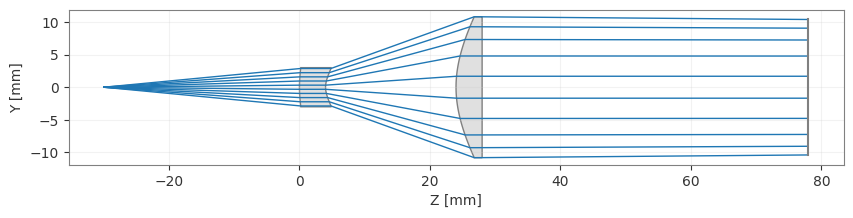

In [46]:
emitter.draw(num_rays=10)

In [54]:
rays = emitter.trace(Hx=0, Hy=0, wavelength=wavelength[0], num_rays=256, distribution="uniform")

intensity = rays.i


print(intensity.shape)

(51040,)
